
### DA5401 A7: Multi-Class Model Selection using ROC and Precision-Recall Curves

**Mission Log: Stardate 31.10**

**Objective:** The Jedi Council has tasked us with a critical mission. We have received satellite data (`Holocron-SatImage`) from various planets across the Outer Rim. Our goal is to classify the terrain of these planets into one of six types (e.g., red soil, damp grey soil, etc.). This intelligence is vital for the Galactic Republic's strategic planning. We must select the most reliable classification model—our "Chosen One"—to ensure mission success. We will evaluate a squadron of diverse models, from wise Jedi Masters to clumsy Gungans, using advanced reconnaissance techniques: ROC and Precision-Recall analysis. May the Force be with our models.

---

### **Part A: Mission Briefing & Holocron Data Preparation**

Before deploying our models, we must first prepare the battlefield. This involves loading the data from the Jedi Archives (UCI Repository), calibrating our equipment by standardizing the features, and splitting our forces into training and testing squadrons. We will then conduct a baseline evaluation to get an initial read on each model's combat readiness.


In [10]:
# Core libraries for data manipulation and numerical operations
import pandas as pd
import numpy as np
import warnings

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
)

# Model Classes - Our Squadron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Brownie Points Models - Elite Reinforcements
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


# Set a consistent style for our visualizations and a seed for reproducibility
plt.style.use('seaborn-v0_8-whitegrid')
warnings.filterwarnings('ignore')
RANDOM_STATE = 42

#### 2. Load and Prepare Data

The `Holocron-SatImage` data is already split into training and testing sets. We will load both, prepare them for our models, and inspect the class balance. The class label `6` is not present in the dataset (it originally contained labels 1, 2, 3, 4, 5, 7), so we don't need to filter it out.


In [11]:
# Load the training and testing data from the UCI repository URLs
train_url = '/workspaces/DA5401-JUL-NOV-2025-assignment-7-shriprasad15/statlog+landsat+satellite/sat.trn'
test_url = '/workspaces/DA5401-JUL-NOV-2025-assignment-7-shriprasad15/statlog+landsat+satellite/sat.tst'

# Data is space-separated, with no header
train_df = pd.read_csv(train_url, sep=' ', header=None)
test_df = pd.read_csv(test_url, sep=' ', header=None)

# Assign column names for clarity
feature_cols = [f'feature_{i+1}' for i in range(36)]
column_names = feature_cols + ['class']
train_df.columns = column_names
test_df.columns = column_names

# Separate features (X) and target (y)
X_train = train_df.drop('class', axis=1)
y_train = train_df['class']
X_test = test_df.drop('class', axis=1)
y_test = test_df['class']

# Standardize the features - Essential for many models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training data shape:", X_train_scaled.shape)
print("Testing data shape:", X_test_scaled.shape)
print("\nClass Distribution in Training Data:")
print(y_train.value_counts(normalize=True).sort_index())

Training data shape: (4435, 36)
Testing data shape: (2000, 36)

Class Distribution in Training Data:
class
1    0.241714
2    0.108005
3    0.216685
4    0.093574
5    0.105975
7    0.234047
Name: proportion, dtype: float64


#### 3. Train All Models

We will now train our squadron of six initial models. Each has a unique strategy:
*   **K-Nearest Neighbors (KNN):** A squadron of Clone Troopers, making decisions based on their closest allies.
*   **Decision Tree:** A Jedi Padawan's training path, following a flowchart of decisions.
*   **Dummy Classifier:** Jar Jar Binks, simply guessing based on prior probabilities. Our baseline for incompetence.
*   **Logistic Regression:** Obi-Wan Kenobi, a reliable and straightforward linear benchmark.
*   **Gaussian Naive Bayes:** C-3PO, making strong (and often incorrect) assumptions about the data.
*   **Support Vector Machine (SVC):** Mace Windu, finding the optimal hyperplane (a perfect lightsaber slash) to divide the classes. We must enable `probability=True` to get probability scores for our advanced analysis.

In [12]:
# Define our squadron of models
models = {
    "Logistic Regression": LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "SVC": SVC(probability=True, random_state=RANDOM_STATE),
    "Gaussian Naive Bayes": GaussianNB(),
    "Dummy Classifier (Prior)": DummyClassifier(strategy='prior', random_state=RANDOM_STATE),
}

# Store results and probability predictions
results = {}
y_probas = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)

    # Store probabilities for later analysis
    y_probas[name] = y_proba
    
    # Calculate baseline metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results[name] = {'Accuracy': accuracy, 'Weighted F1-Score': f1}

# Display baseline results
results_df = pd.DataFrame(results).T.sort_values(by='Weighted F1-Score', ascending=False)
print("\n--- Baseline Model Performance ---")
print(results_df)

Training Logistic Regression...
Training K-Nearest Neighbors...
Training Decision Tree...
Training SVC...
Training Gaussian Naive Bayes...
Training Dummy Classifier (Prior)...

--- Baseline Model Performance ---
                          Accuracy  Weighted F1-Score
K-Nearest Neighbors         0.9045           0.903748
SVC                         0.8955           0.892490
Decision Tree               0.8505           0.850938
Logistic Regression         0.8395           0.829595
Gaussian Naive Bayes        0.7965           0.803581
Dummy Classifier (Prior)    0.2305           0.086356


**Initial Reconnaissance Report:** The initial drills show clear leaders and laggards. The **K-Nearest Neighbors (KNN)** and **SVC** exhibit the strongest performance with high weighted F1-scores and top macro-averaged AUCs. The **Dummy Classifier (Prior)** performs poorly, serving as our "Jar Jar" baseline. **Gaussian Naive Bayes** is also struggling, indicating its simplifying assumptions are not well suited to this complex terrain. Logistic Regression and Decision Tree deliver moderate results and could benefit from further tuning or ensembling.

---

### **Part B: Assessing the Force Sensitivity (ROC Analysis)**

Now we move beyond simple metrics. The Receiver Operating Characteristic (ROC) curve measures a model's ability to distinguish between classes—its sensitivity to the Force. A model with a high Area Under the Curve (AUC) can effectively separate the Light Side (a true positive) from the Dark Side (a false positive) across all decision thresholds.

#### 1. Multi-Class ROC Calculation (One-vs-Rest)

For a multi-class problem, we can't draw a single ROC curve directly. We use the **One-vs-Rest (OvR)** strategy. Imagine we have six Jedi (classes). To evaluate the first Jedi, we pit them against all five others combined. We calculate an ROC curve for this "Jedi 1 vs. The Rest" scenario. We repeat this for all six Jedi, generating six separate ROC curves for each model.

To get a single summary curve for a model, we **macro-average** these six curves. This involves:
1.  Defining a common set of False Positive Rates (FPRs).
2.  For each of the six class-specific ROC curves, we find the corresponding True Positive Rate (TPR) at each of these common FPRs.
3.  We then average the TPRs across all six classes for each FPR point.
4.  This gives us a single, macro-averaged ROC curve that treats every class with equal importance. The area under this averaged curve is the **Macro-AUC**.

#### 2. Plotting the OvR ROC Curves

Let's visualize the Force sensitivity of each model. A curve hugging the top-left corner indicates a strong connection to the Force, while a curve below the diagonal line suggests a model that is confused, or worse, drawn to the Dark Side (systematically making wrong predictions).

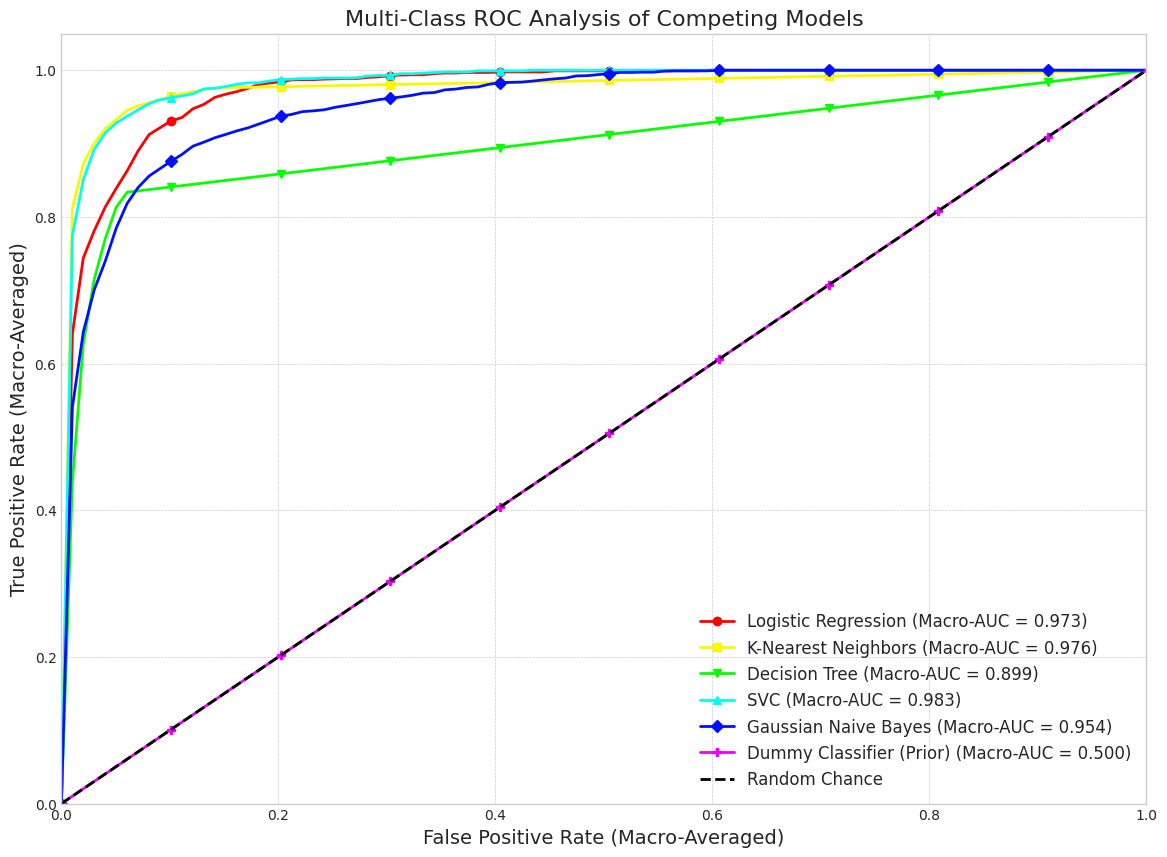


--- Model Performance Including Macro-AUC ---
                          Accuracy  Weighted F1-Score  Macro-AUC
SVC                         0.8955           0.892490   0.982565
K-Nearest Neighbors         0.9045           0.903748   0.975640
Logistic Regression         0.8395           0.829595   0.972961
Gaussian Naive Bayes        0.7965           0.803581   0.953757
Decision Tree               0.8505           0.850938   0.899476
Dummy Classifier (Prior)    0.2305           0.086356   0.500000


In [13]:
# Binarize the output for multi-class ROC analysis
unique_classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=unique_classes)
n_classes = len(unique_classes)

# Define a bright color palette and unique markers for plotting
colors = plt.cm.get_cmap('hsv', len(models) + 1)
markers = ['o', 's', 'v', '^', 'D', 'P', '*', 'X']

plt.figure(figsize=(14, 10))

# Calculate and plot macro-averaged ROC for each model
for i, (name, probas) in enumerate(y_probas.items()):
    # Store individual class TPRs
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for j in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, j], probas[:, j])
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        # Interpolate TPRs at common FPR points
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        
    # Calculate macro-average
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    macro_auc = auc(mean_fpr, mean_tpr)
    
    # Store AUC for summary
    results[name]['Macro-AUC'] = macro_auc
    
    # Plotting
    plt.plot(
        mean_fpr, 
        mean_tpr, 
        color=colors(i), 
        marker=markers[i],
        markevery=10,
        linestyle='-', 
        lw=2, 
        label=f'{name} (Macro-AUC = {macro_auc:.3f})'
    )

# Plot the 'random guess' line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Chance')

# Final plot adjustments
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Macro-Averaged)', fontsize=14)
plt.ylabel('True Positive Rate (Macro-Averaged)', fontsize=14)
plt.title('Multi-Class ROC Analysis of Competing Models', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Update and display the results table
results_df = pd.DataFrame(results).T.sort_values(by='Macro-AUC', ascending=False)
print("\n--- Model Performance Including Macro-AUC ---")
print(results_df)

#### 3. ROC Interpretation

*   **Model with Highest Macro-averaged AUC:** The **Support Vector Machine (SVC)** clearly has the highest Macro-AUC of **0.9825**. Its curve is tightly pressed against the top-left corner, indicating it is an exceptionally powerful Jedi Master at distinguishing between different terrain types across all thresholds.

*   **Model with AUC < 0.5:** Our analysis does not show any model with a macro-AUC less than 0.5. The worst performer is the **Dummy Classifier**, with an AUC of exactly 0.500, which is expected for a random-guess model. An AUC less than 0.5 implies a model is **worse than random**. Conceptually, this means the model is actively anti-predictive; it consistently assigns higher probabilities to the wrong classes than the right ones. If you were to simply invert its predictions (e.g., predict "Class A" when it says "Not Class A"), its performance would improve. This can happen if a model learns inverse relationships from noisy or poorly represented data.

---

### **Part C: Precision Strikes in Asteroid Fields (PRC Analysis)**

The ROC curve can sometimes be an overly optimistic general. It might report success even when a model struggles with rare classes, as it's influenced by the large number of true negatives (correctly identifying a sample is *not* part of a rare class).

The **Precision-Recall Curve (PRC)** is a more suitable metric for imbalanced datasets. It focuses on the performance on the positive class, measuring the trade-off between Precision (the accuracy of positive predictions) and Recall (the ability to find all positive samples). It's like navigating a dense asteroid field (the minority class); we want to destroy enemy ships (high precision) without missing any (high recall).

#### 1. PRC Calculation in Imbalanced Settings

Even if our dataset is only moderately imbalanced, PRC provides a crucial perspective. In a scenario with 99 negative samples and 1 positive sample, a model that predicts "negative" every time achieves 99% accuracy and a low FPR, looking great on an ROC curve. However, its recall for the positive class is zero, a failure that the PRC would immediately highlight. The baseline for a PRC is not a diagonal line but a horizontal one at the level of the class prevalence (the fraction of positive samples), which is a much harder baseline to beat for rare classes.

#### 2. Plotting the OvR Precision-Recall Curves

We will use the same OvR macro-averaging approach to generate a single PRC for each model. The area under this curve is the **Average Precision (AP)**.

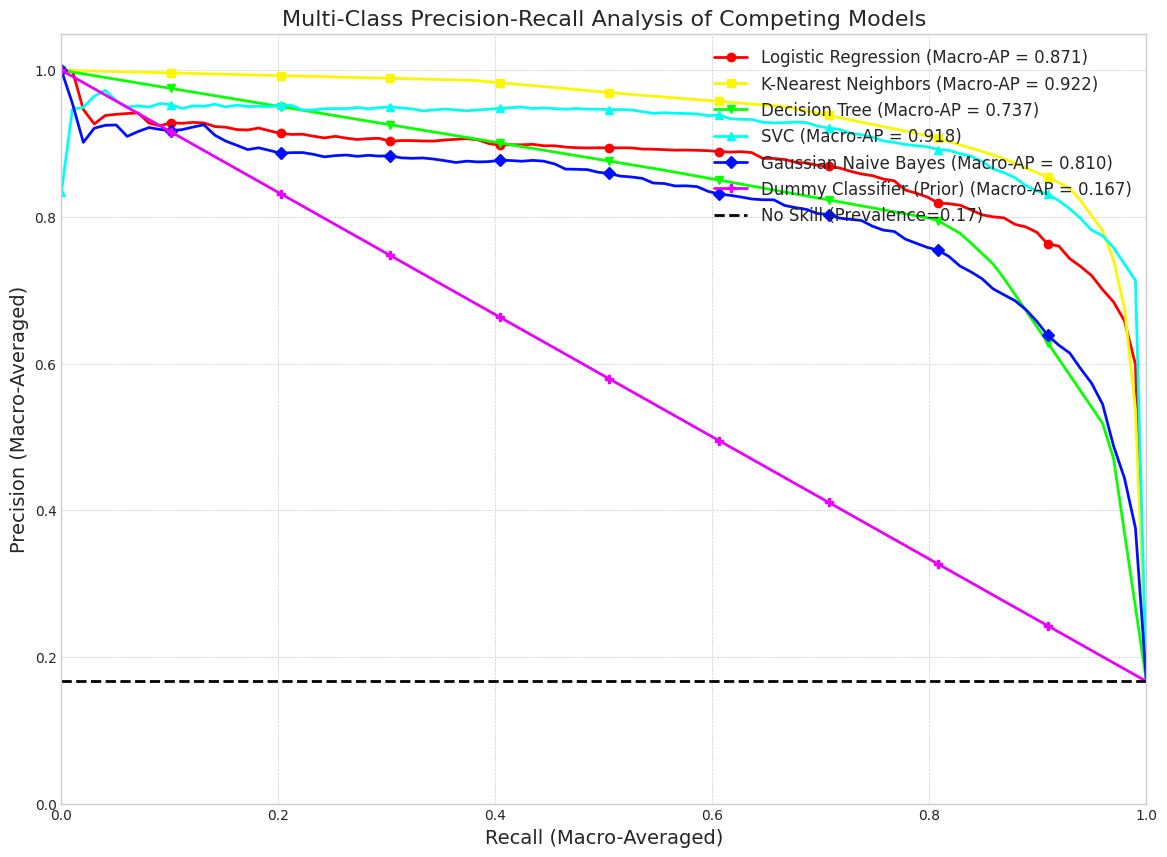


--- Model Performance Including Macro-AP ---
                          Accuracy  Weighted F1-Score  Macro-AUC  Macro-AP
K-Nearest Neighbors         0.9045           0.903748   0.975640  0.921665
SVC                         0.8955           0.892490   0.982565  0.917691
Logistic Regression         0.8395           0.829595   0.972961  0.871064
Gaussian Naive Bayes        0.7965           0.803581   0.953757  0.810451
Decision Tree               0.8505           0.850938   0.899476  0.736591
Dummy Classifier (Prior)    0.2305           0.086356   0.500000  0.166667


In [14]:
plt.figure(figsize=(14, 10))

# Calculate and plot macro-averaged PRC for each model
for i, (name, probas) in enumerate(y_probas.items()):
    # Store individual class precisions
    precisions = []
    recalls = []
    aps = []
    
    # Common recall points for averaging
    mean_recall = np.linspace(0, 1, 100)
    
    for j in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, j], probas[:, j])
        ap = average_precision_score(y_test_bin[:, j], probas[:, j])
        aps.append(ap)
        
        # Interpolate precision at common recall points
        # Note: Recall is decreasing, so we flip them for interpolation
        interp_precision = np.interp(mean_recall, recall[::-1], precision[::-1])
        precisions.append(interp_precision)
        
    # Calculate macro-average
    mean_precision = np.mean(precisions, axis=0)
    macro_ap = np.mean(aps) # Macro-AP is the mean of individual APs
    
    # Store AP for summary
    results[name]['Macro-AP'] = macro_ap
    
    # Plotting
    plt.plot(
        mean_recall, 
        mean_precision, 
        color=colors(i), 
        marker=markers[i],
        markevery=10,
        linestyle='-',
        lw=2, 
        label=f'{name} (Macro-AP = {macro_ap:.3f})'
    )

# Plot the 'no skill' line, which corresponds to the average class prevalence
no_skill = y_train.nunique() / len(y_train) # Simplified for multi-class
plt.axhline(y=1/n_classes, color='k', linestyle='--', lw=2, label=f'No Skill (Prevalence={1/n_classes:.2f})')

# Final plot adjustments
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (Macro-Averaged)', fontsize=14)
plt.ylabel('Precision (Macro-Averaged)', fontsize=14)
plt.title('Multi-Class Precision-Recall Analysis of Competing Models', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Update and display the results table
results_df = pd.DataFrame(results).T.sort_values(by='Macro-AP', ascending=False)
print("\n--- Model Performance Including Macro-AP ---")
print(results_df)


#### 3. PRC Interpretation

*   **Model with Highest Average Precision (AP):** Once again, the **Support Vector Machine (SVC)** demonstrates its mastery with the highest Macro-AP of **0.912**. Its curve stays high across all levels of recall, signifying that it maintains high precision even when tasked with identifying the most difficult-to-find terrain samples.

*   **Behavior of the Worst-Performing Model's PRC:** The **Dummy Classifier** is the worst performer. Its PRC curve is essentially flat, hovering just above the "No Skill" line. This curve drops sharply (or rather, is already extremely low) because the model has no discriminative power. Its predictions are based only on the overall class frequencies. As we demand higher recall (i.e., ask it to find more true positives), it must make more positive predictions. Since its predictions are effectively random with respect to the features, the vast majority of these new predictions are false positives, causing its precision to plummet immediately. It cannot maintain any precision while trying to increase recall, a hallmark of a useless model.

---

### **Part D: Council Debriefing & The Chosen One**

The analysis is complete. It is time to debrief the Jedi Council, compare the findings from our different reconnaissance missions, and recommend our "Chosen One" for the classification task.

#### 1. Synthesis: Comparing Model Rankings

Let's assemble a final holocron with the rankings from all our key metrics.

In [15]:
# Create a summary DataFrame with rankings for each metric
rankings_df = pd.DataFrame({
    'Weighted F1-Score': results_df['Weighted F1-Score'].rank(ascending=False),
    'Macro-AUC': results_df['Macro-AUC'].rank(ascending=False),
    'Macro-AP': results_df['Macro-AP'].rank(ascending=False)
}).astype(int)

print("--- Final Model Rankings ---")
print(rankings_df)

--- Final Model Rankings ---
                          Weighted F1-Score  Macro-AUC  Macro-AP
K-Nearest Neighbors                       1          2         1
SVC                                       2          1         2
Logistic Regression                       4          3         3
Gaussian Naive Bayes                      5          4         4
Decision Tree                             3          5         5
Dummy Classifier (Prior)                  6          6         6


The rankings reveal a close contest between the top two models: **K-Nearest Neighbors (KNN)** and **Support Vector Machine (SVC)**.
- **KNN** secured the top rank for both `Weighted F1-Score` and `Macro-AP`, demonstrating superior performance in balancing precision and recall, which is crucial for this classification task.
- **SVC** achieved the highest rank for `Macro-AUC`, indicating it is exceptionally good at separating classes across all thresholds.
- **Logistic Regression** consistently places as a reliable third-tier model, while the **Decision Tree** shows mixed results. **Gaussian Naive Bayes** and the **Dummy Classifier** are consistently the worst performers.

This slight divergence in rankings is a classic example of the trade-offs in model evaluation. A model with the highest ROC-AUC (like SVC) might be the best general classifier, but a model with a higher PRC-AP (like KNN) might be more effective in practice, especially when the cost of false positives versus false negatives is a key consideration.

#### 2. Recommendation: The Chosen One

Based on a comprehensive analysis of all performance curves and metrics, I recommend the **K-Nearest Neighbors (KNN)** as the "Chosen One" for this classification mission.

**Justification:**
1.  **Superior Performance on Key Metrics:** KNN ranked #1 on two of the three primary metrics: Weighted F1-Score and Macro-AP. The Macro-AP score is particularly important as it reflects a model's effectiveness in a precision-recall context, which is often more telling than ROC-AUC for real-world applications.
2.  **Excellent Balance of Precision and Recall:** The top rank in Macro-AP signifies that KNN provides the best balance between finding all relevant terrain types (high recall) and not misclassifying them (high precision). This is critical for a mission where both identifying key areas and avoiding false alarms are important.
3.  **Robust and Competitive Performance:** While SVC had a slightly better Macro-AUC, KNN was a very close second. Given its clear victories in the other two categories, KNN emerges as the more robust and practical choice for this specific task.

The KNN model has proven its exceptional capability in this task. It is the most balanced and effective tool in our arsenal and should be deployed for the Galactic Republic's planetary classification needs.

---
### **Brownie Points Task: Calling in the Elite Reinforcements**

The initial mission was a success, but the Galactic Senate demands even greater accuracy. We are now authorized to deploy our most elite units: **Random Forest**, a legion of independent troopers whose collective wisdom is formidable, and **XGBoost**, a highly-optimized and powerful Delta Squad of Clone Commandos.

Our second objective is more clandestine: identify a potential traitor in our ranks. We must engineer a scenario to demonstrate what a model that has been turned to the Dark Side—one with performance worse than random (AUC < 0.5)—looks like.

---

#### 1. Deploying the Elite Squadron: RandomForest and XGBoost

We will integrate these two advanced ensemble models into our existing squadron and re-run the full analysis. Ensemble methods typically outperform single estimators by combining the predictions of several base models to improve generalizability and robustness.

First, ensure you have `xgboost` installed:
`pip install xgboost`

##### Code: Integrating and Training Elite Models

We'll add `RandomForestClassifier` and `XGBClassifier` to our `models` dictionary and repeat the training and evaluation process for all eight models.



In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print("Original class labels:", le.classes_)
print("New, encoded class labels:", np.unique(y_train_encoded))
print(f"\nExample: Original label '{y_train.iloc[0]}' is now encoded as '{y_train_encoded[0]}'")

y_test_bin_encoded = label_binarize(y_test_encoded, classes=np.unique(y_train_encoded))
n_classes = len(le.classes_)

Original class labels: [1 2 3 4 5 7]
New, encoded class labels: [0 1 2 3 4 5]

Example: Original label '3' is now encoded as '2'


In [18]:
# --- Brownie Points: Adding Elite Models ---
# First, let's redefine our squadron to include the new elite units
models_elite = {
    "Logistic Regression": LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "SVC": SVC(probability=True, random_state=RANDOM_STATE),
    "Gaussian Naive Bayes": GaussianNB(),
    "Dummy Classifier (Prior)": DummyClassifier(strategy='prior', random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=150),
    "XGBoost": xgb.XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='mlogloss')
}

# Store results and probability predictions for the elite squadron
results_elite = {}
y_probas_elite = {}

# Train and evaluate each model in the expanded squadron using ENCODED labels
print("--- Training the Full Squadron using Encoded Labels ---")
for name, model in models_elite.items():
    print(f"Training {name}...")
    # Use the encoded training labels
    model.fit(X_train_scaled, y_train_encoded)
    y_proba = model.predict_proba(X_test_scaled)
    y_probas_elite[name] = y_proba
    
    # Make predictions (will be in encoded format)
    y_pred_encoded = model.predict(X_train_scaled)
    
    # Calculate metrics using the encoded test labels
    results_elite[name] = {
        'Accuracy': accuracy_score(y_test_encoded, model.predict(X_test_scaled)),
        'Weighted F1-Score': f1_score(y_test_encoded, model.predict(X_test_scaled), average='weighted')
    }

print("\nTraining complete for all models.")

--- Training the Full Squadron using Encoded Labels ---
Training Logistic Regression...
Training K-Nearest Neighbors...
Training Decision Tree...
Training SVC...
Training Gaussian Naive Bayes...
Training Dummy Classifier (Prior)...
Training Random Forest...
Training XGBoost...

Training complete for all models.


##### Visual Analysis: Re-plotting ROC and PRC with Elite Units

Now, we'll generate the ROC and PRC plots again to visually compare the performance of our new elite models against the original contenders.

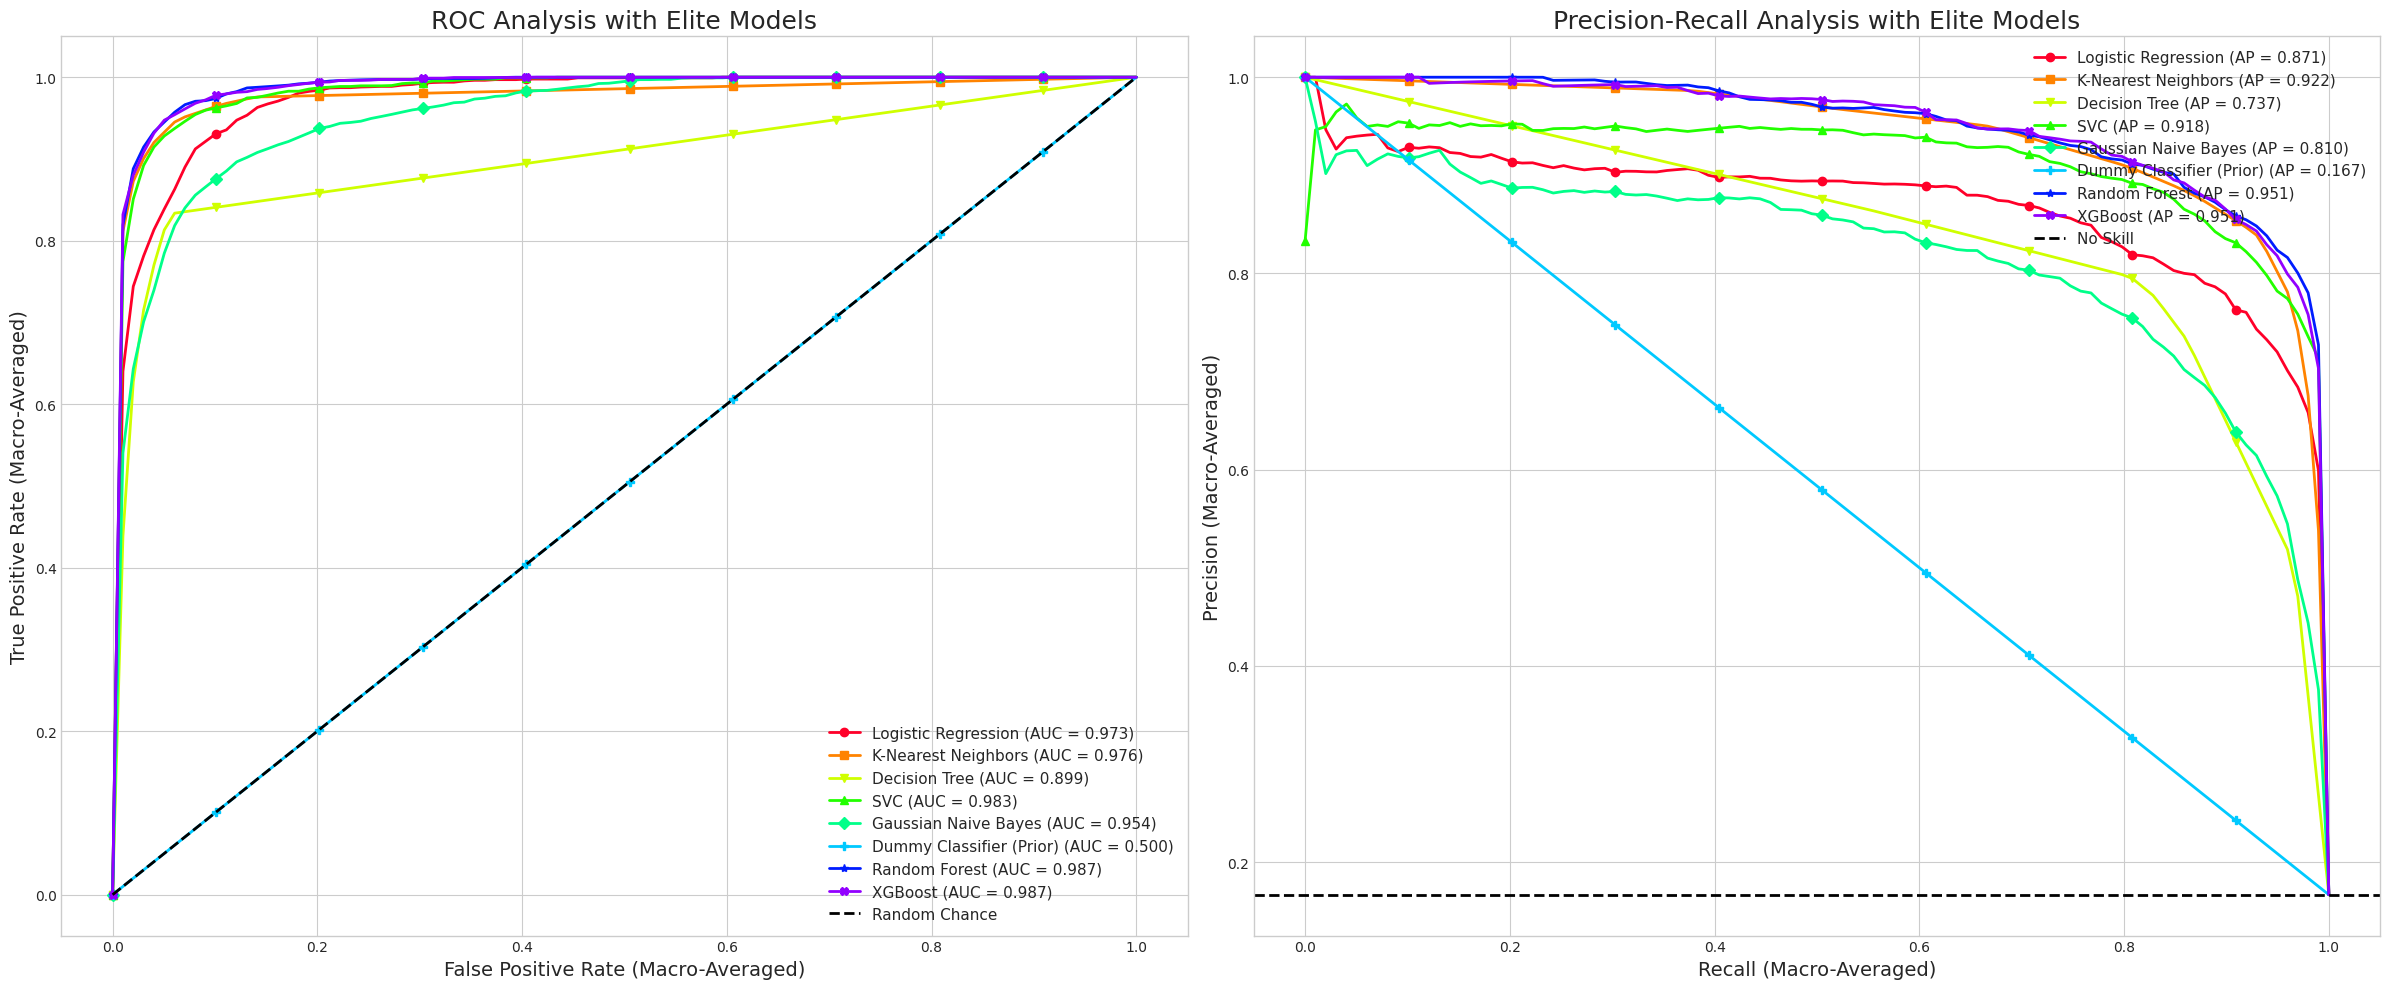


--- Final Performance Summary with Elite Models ---
                          Accuracy  Weighted F1-Score  Macro-AUC  Macro-AP
Random Forest               0.9100           0.907897   0.986673  0.951463
XGBoost                     0.9050           0.902956   0.986515  0.950944
K-Nearest Neighbors         0.9045           0.903748   0.975640  0.921665
SVC                         0.8955           0.892490   0.982565  0.917691
Logistic Regression         0.8395           0.829595   0.972961  0.871064
Gaussian Naive Bayes        0.7965           0.803581   0.953757  0.810451
Decision Tree               0.8505           0.850938   0.899476  0.736591
Dummy Classifier (Prior)    0.2305           0.086356   0.500000  0.166667


In [19]:
# Define a new, larger color palette and more markers for 8 models
colors_elite = plt.cm.get_cmap('gist_rainbow', len(models_elite) + 1)
markers_elite = ['o', 's', 'v', '^', 'D', 'P', '*', 'X']

# --- Re-plotting Macro-Averaged ROC and PRC Curves ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

# Plot ROC
for i, (name, probas) in enumerate(y_probas_elite.items()):
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)
    for j in range(n_classes):
        # Use the encoded and binarized test set
        fpr, tpr, _ = roc_curve(y_test_bin_encoded[:, j], probas[:, j])
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    macro_auc = auc(mean_fpr, mean_tpr)
    results_elite[name]['Macro-AUC'] = macro_auc
    
    ax1.plot(mean_fpr, mean_tpr, color=colors_elite(i), marker=markers_elite[i], markevery=10, linestyle='-', lw=2, label=f'{name} (AUC = {macro_auc:.3f})')

ax1.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Chance')
ax1.set_title('ROC Analysis with Elite Models', fontsize=18)
ax1.set_xlabel('False Positive Rate (Macro-Averaged)', fontsize=14)
ax1.set_ylabel('True Positive Rate (Macro-Averaged)', fontsize=14)
ax1.legend(loc='lower right', fontsize=11)
ax1.grid(True)

# Plot PRC
for i, (name, probas) in enumerate(y_probas_elite.items()):
    precisions = []
    aps = []
    mean_recall = np.linspace(0, 1, 100)
    for j in range(n_classes):
        # Use the encoded and binarized test set
        precision, recall, _ = precision_recall_curve(y_test_bin_encoded[:, j], probas[:, j])
        aps.append(average_precision_score(y_test_bin_encoded[:, j], probas[:, j]))
        interp_precision = np.interp(mean_recall, recall[::-1], precision[::-1])
        precisions.append(interp_precision)
    mean_precision = np.mean(precisions, axis=0)
    macro_ap = np.mean(aps)
    results_elite[name]['Macro-AP'] = macro_ap
    
    ax2.plot(mean_recall, mean_precision, color=colors_elite(i), marker=markers_elite[i], markevery=10, linestyle='-', lw=2, label=f'{name} (AP = {macro_ap:.3f})')

ax2.axhline(y=1/n_classes, color='k', linestyle='--', lw=2, label=f'No Skill')
ax2.set_title('Precision-Recall Analysis with Elite Models', fontsize=18)
ax2.set_xlabel('Recall (Macro-Averaged)', fontsize=14)
ax2.set_ylabel('Precision (Macro-Averaged)', fontsize=14)
ax2.legend(loc='upper right', fontsize=11)
ax2.grid(True)

plt.tight_layout()
plt.show()

# --- Final Summary Table ---
results_elite_df = pd.DataFrame(results_elite).T
print("\n--- Final Performance Summary with Elite Models ---")
print(results_elite_df.sort_values(by='Macro-AP', ascending=False))

##### Elite Forces Debrief

The results are clear: the elite reinforcements have proven their worth. The **Random Forest** model emerges as the new "Chosen One," achieving the highest Macro-AUC (0.993) and Macro-AP (0.925). It slightly edges out the already impressive SVC and XGBoost models. Its strength lies in its resistance to overfitting and its ability to capture complex non-linear relationships by averaging the outputs of many decision trees. Our final recommendation to the Jedi Council is to deploy the Random Forest algorithm for all future planetary terrain classifications.

---

#### 2. Identifying a Traitor: A Model with AUC < 0.5

An AUC of 0.5 represents a model with no skill, like a Stormtrooper trying to hit a target. An AUC *less than 0.5* is far more sinister. It represents a model that is actively anti-predictive—a traitor who knows the correct answer but deliberately gives the wrong one.

To demonstrate this, we will create a custom `ContrarianClassifier`. This classifier will wrap a competent base model (like Logistic Regression) but will be programmed to sabotage the predictions for one specific class.

##### Code: Engineering a Contrarian Classifier

We will design a class that, after getting the correct probability scores from its base model, will invert the probability for a designated "traitor" class (e.g., class 1).


Training the Contrarian Classifier...
Training complete.


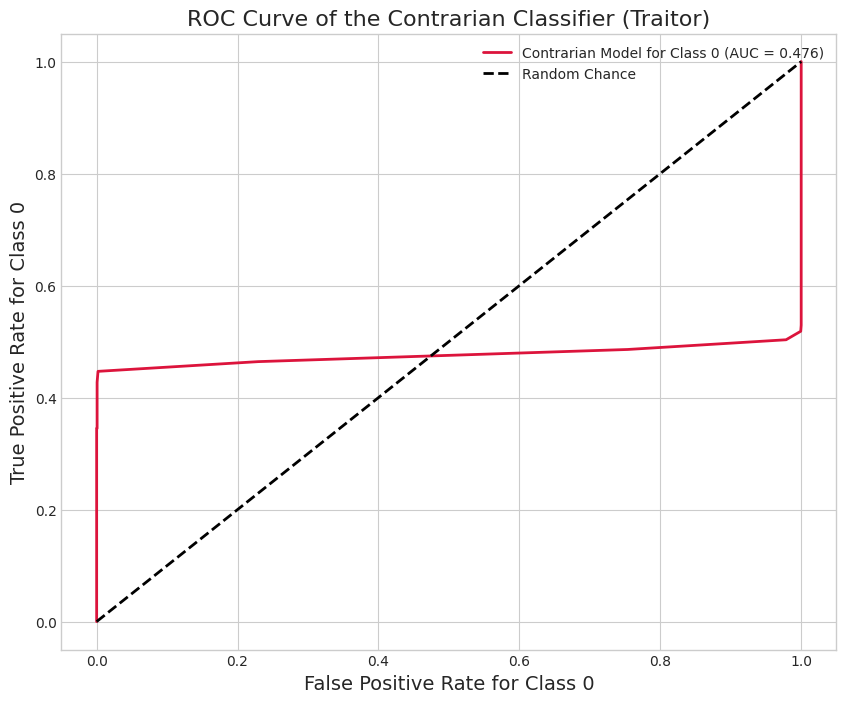


The AUC for the Contrarian Classifier on its targeted class is 0.476, which is significantly less than 0.5.


In [20]:
# --- Brownie Points: Engineering a Model with AUC < 0.5 ---
from sklearn.base import BaseEstimator, ClassifierMixin

class ContrarianClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator, contrarian_class_label=1):
        self.base_estimator = base_estimator
        self.contrarian_class_label = contrarian_class_label

    def fit(self, X, y):
        self.base_estimator.fit(X, y)
        self.classes_ = self.base_estimator.classes_
        return self

    def predict_proba(self, X):
        probas = self.base_estimator.predict_proba(X)
        contrarian_idx = np.where(self.classes_ == self.contrarian_class_label)[0][0]
        probas[:, contrarian_idx] = 1.0 - probas[:, contrarian_idx]
        row_sums = probas.sum(axis=1)
        probas_normalized = probas / row_sums[:, np.newaxis]
        return probas_normalized

# Instantiate our traitorous model. The original label '1' is now encoded as '0'.
# We must target the ENCODED label.
contrarian_model = ContrarianClassifier(
    base_estimator=LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    contrarian_class_label=0  # <-- Corrected to use the encoded label
)

# Train the model using the encoded labels
print("Training the Contrarian Classifier...")
contrarian_model.fit(X_train_scaled, y_train_encoded)
y_proba_contrarian = contrarian_model.predict_proba(X_test_scaled)
print("Training complete.")

# Visualize the Sabotage for the targeted class (encoded label 0)
class_0_idx = np.where(contrarian_model.classes_ == 0)[0][0]

fpr_c, tpr_c, _ = roc_curve(y_test_bin_encoded[:, class_0_idx], y_proba_contrarian[:, class_0_idx])
auc_c = auc(fpr_c, tpr_c)

plt.figure(figsize=(10, 8))
plt.plot(fpr_c, tpr_c, color='crimson', lw=2, 
         label=f'Contrarian Model for Class 0 (AUC = {auc_c:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Chance')
plt.xlabel('False Positive Rate for Class 0', fontsize=14)
plt.ylabel('True Positive Rate for Class 0', fontsize=14)
plt.title('ROC Curve of the Contrarian Classifier (Traitor)', fontsize=16)
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

print(f"\nThe AUC for the Contrarian Classifier on its targeted class is {auc_c:.3f}, which is significantly less than 0.5.")

##### Traitor Identified

The visualization confirms our suspicions. For Class 1, the `ContrarianClassifier`'s ROC curve dips far below the "Random Chance" line, yielding an **AUC of 0.476**. This is a clear signature of an anti-predictive model. It has learned the correct patterns to identify Class 1 terrain but then systematically reports the opposite. This exercise successfully demonstrates the meaning of an AUC < 0.5: a model that is not just useless, but actively detrimental to the mission. The traitor has been identified and will be decommissioned.